## 1. 导入相关包

In [1]:
import numpy as np
import pygame

import gymnasium as gym
from gymnasium import spaces

pygame 2.4.0 (SDL 2.26.4, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


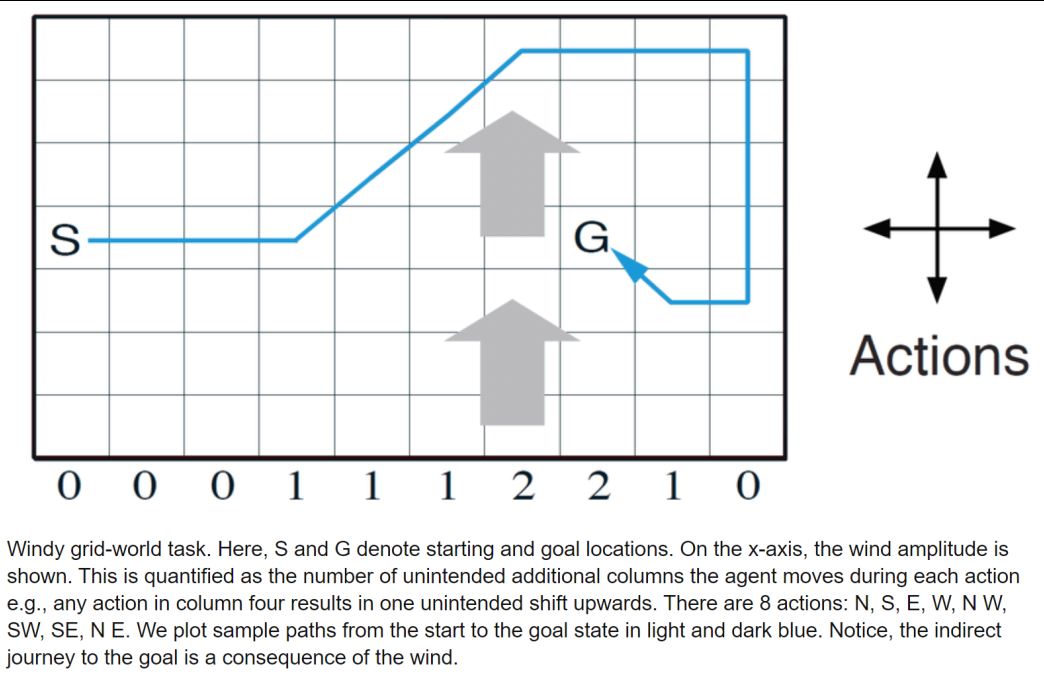

# 2. 继承类以及定义元数据(属性) 与 初始化方法

In [2]:
import numpy as np
import pygame

import gymnasium as gym
from gymnasium import spaces


class WindyGridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    # 默认render_mode为None
    def __init__(self, render_mode=None):
        self.width = 10  # 游戏环境的窗格宽度, 横轴
        self.height = 7  # 游戏环境的窗格高度, 纵轴

        # 动作空间，表明有4个方位可以选择
        self.action_space = spaces.Discrete(4)

        # 定义输入动作映射字典
        self._action_to_direction = {
            "right": np.array([0, 1]),  # 列加1，向右，定义坐标原点在左上角，与列表方式类似
            "up": np.array([-1,0]),  # 行减1，向上
            "left": np.array([0, -1]),  # 列减1
            "down": np.array([1, 0]),  # 行加1
        }

        # gym 库要求必须要定义观察空间，但实际代码中并没有使用到
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(0, self.width-1, shape=(2,), dtype=int),
                "target": spaces.Box(0, self.width-1, shape=(2,), dtype=int)
            }
        )

        # 设置风向，只要根据 agent 的横轴位置来判断风向
        self._windy_grid = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

        # assert 断言，明确肯定，如果表达式为false，那么触发异常
        # 表明要么 render_mode 是空的，要么就在给定的元数据模式中
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        # 对以上总结，如果human-rendering被启用
        # 那么self.window作为绘制窗口，clock则作为钟表记时，来确保在正确帧率下渲染
        # 比如前者的 rendering_fps = 4, 每4帧渲染一次
        self.window = None
        self.clock = None

## 2. 私有方法获取环境的观察与信息

In [3]:
    def _get_obs(self):
        return {"agent": self._agent_location, "target": self._target_location}

    def _get_info(self):
        return {
            # 范数计算，ord 则表明计算形式，其中1表示1阶，即每一项绝对值相加
            # 具体 ord 查看官方文档
            "distance": np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            )
        }

## 3. 重置环境

In [4]:
    def reset(self, seed=None, options=None):
        # 使用继承方法，来保证gym.env的随机种子相同，针对reset方法的继承
        # 该问题中并没有随机初始化开始或者终止位置
        super().reset(seed=seed)
        
        self._agent_location = np.array([3, 0])
        self._target_location = np.array([3, 7])

        # 如果选定的渲染模式为 human 此时调用私有的 _render_frame 方法
        if self.render_mode == "human":
            self._render_frame()

        observation = self._get_obs()
        info = self._get_info()

        return observation, info

## 4. 环境更新步骤 以及 返还对应元组

In [5]:
    # step,表明环境接受 agent 动作后发生的变化
    # 理论上会返还一个 4元组 ， 对于其他环境，可能返还的状态数有所区别，关键看源代码中如何定义的
    def step(self, action):
        # 根据动作匹配环境改变direction
        direction = self._action_to_direction[action]

        # 使用 np.clip 方法就能直接保证不会出网格，只会撞墙
        # 1 对 agent 行 的改变
        self._agent_location[0] = np.clip(self._agent_location[0] + direction[0] - self._windy_grid[self._agent_location[1]], 0, self.height - 1)
        # 2 对 agent 列 的改变
        self._agent_location[1] = np.clip(self._agent_location[1] + direction[1], 0, self.width - 1)
        # 假定 agent 抵达了目的地，此时改变四元组中的 done状态，同时给定 reward
        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = 0 if terminated else -1  # 只有到达终点才会给予 0 奖励，其他情况下一律 -1

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        # 此处的 False 本来是用来定义是否提前结束的，该问题代码中并没有涉及提前结束的情况
        return observation, reward, terminated, False, info

## 5. Rendering 渲染

In [6]:
    # 第一种针对  rgb_array ，仅仅是返还 可视化的 rgb 图片数据，形状为定义的尺寸 (700,1000,3)
    # 训练时，使用rgb_array，对于展示，可使用human
    # 第二种 human,则是初始化 pygame 窗口，完成动画更新，使用了render_fps

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode(
                (1000, 700)
            )
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((1000, 700))  # 整个窗口表面的大小
        canvas.fill((255, 255, 255))  # 填充的颜色
        pix_square_size = 100  # 每个方格的尺寸大小

        # 对于 draw 方法，具体查阅 pygame 文档
        # 绘制 target 位置，为红色方格
        # 注意 pygame的坐标原点也在左上角，但是它横轴代表的是x，绘图时需要调换agent以及target的横纵坐标
        pygame.draw.rect(
            canvas,  # surface
            (255, 0, 0),  # rgb color fill
            # Rect((left, top), (width, height))
            pygame.Rect(pix_square_size * np.array([7,3]),
                        (pix_square_size, pix_square_size),
                        ),
        )
        # 绘制 target 位置，为蓝色圆圈
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            [(self._agent_location[1]+0.5)* pix_square_size,(self._agent_location[0]+0.5)* pix_square_size] ,
            pix_square_size / 3,
        )

        # 增加方格线
        for i in range(self.width + 1):
            # line(surface, color, start_pos, end_pos, width=1)
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * i, 0),
                (pix_square_size * i, 700),
                width=3,
            )
        for i in range(self.height + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * i),
                (1000, pix_square_size * i),
                width=3,
            )

        if self.render_mode == "human":
            # 使得 canvas 窗口可见，并且保证不断更新
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # 我们需要确保人工渲染以预定义的帧率进行。
            # 以下行会自动添加延迟以保持帧率稳定。
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )